In [49]:
# import packages
from toolsets.search import string_search, quick_search_sorted, quick_search_values
# general tools
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
# RDkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
import matplotlib.pyplot as plt
# Pytorch and Pytorch Geometric
import pandas as pd
import torch
import os
from matplotlib.offsetbox import AnchoredText
import toolsets.chem_utils as cu
from torch_geometric.data import Data
from torch.utils.data import DataLoader
import pandas as pd
from math import sqrt
from toolsets.file_io import read_df, save_df
from torch_geometric.utils import from_smiles, to_networkx
import torch.nn.functional as F
from torch.utils.data import random_split
import seaborn as sns
import toolsets.torch_utilities as tu
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.nn import AttentiveFP
import torch.nn as nn
from rdkit.Chem.Descriptors import ExactMolWt
from tqdm import tqdm
%load_ext autoreload
%autoreload 2
from functools import partial
import os
import tempfile
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle
import deepchem as dc
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
from dgl import DGLGraph

In [6]:
data_dir = '/Users/fanzhoukong/Documents/GitHub/Rhoeto/mini_dataset'
model_dir = '/Users/fanzhoukong/Documents/GitHub/Rhoeto/models'

# start off by reading the training and testing data

In [7]:
train_alc = pd.read_csv(os.path.join(data_dir, 'train_alc.csv'))
test_alc = pd.read_csv(os.path.join(data_dir, 'test_alc.csv'))
# train_md = pd.read_csv(os.path.join(data_dir, 'train_alc_descriptors.csv'))
# test_md = pd.read_csv(os.path.join(data_dir, 'test_alc_descriptors.csv'))

In [305]:
def test_accuracy(model, test_loader, if_training = False):
    creterion = nn.MSELoss()
    model.eval()
    device = 'cpu'
    with torch.no_grad():
        output = []
        # smi = []
        for data in test_loader:
            # data = data.to(device)
            out = model(data[0])
            concatenated_data = torch.cat((out, data[1].view(-1, 1)), dim=1)
            output.append(concatenated_data)
            # smi.append(data.smiles)
        stacked_output = torch.cat(output, dim=0)
        # stacked_smiles = np.concatenate(smi)
        results = pd.DataFrame(stacked_output, columns=['pred', 'actual'])
    rmse = sqrt(mean_squared_error(results['pred'], results['actual']))
    mae = np.median(abs(results['pred'] - results['actual']))
    print(f'the rmse is {rmse:.4f}. The mae is {mae:.4f}')
    # return results








    # with torch.no_grad():
    #     predicted = model(x_torch)
    #     mse = criterion(predicted, y_torch)
    #     rmse = np.sqrt(mse.item())
    #     diff = abs(predicted - y_torch)
    #     mae = np.median(diff.numpy())
    # if if_training:
    #     print('this is training data')
    # print(f'The RMSE is {rmse:.4f}, the MAE is {mae:.4f}')

In [6]:
train_md

,rt,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,48.462066,23.054644,16.332324,1,1,0,0,81,33,0,...,0.000000,9.377125,66.455268,489.321925,6.041011,5548,33,134.0,135.0,8.166667
1,106.223094,36.886792,25.272641,2,1,0,0,126,52,0,...,0.000000,9.941409,88.034155,759.505034,6.027818,16953,57,218.0,224.0,12.611111
2,198.747038,41.916176,26.179902,1,1,0,0,159,59,0,...,0.000000,10.009513,95.534715,857.723741,5.394489,26392,61,246.0,249.0,14.291667
3,238.318719,43.461683,26.566649,0,0,0,0,162,62,0,...,0.000000,9.852878,98.290303,868.751991,5.362667,29145,64,250.0,253.0,15.500000
4,168.933478,38.449592,25.710853,1,1,0,0,147,54,0,...,0.000000,10.019803,90.317088,788.677125,5.365151,19179,58,228.0,233.0,12.986111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,125.392783,37.782925,25.456690,1,1,0,0,133,53,0,...,0.000000,9.981605,89.195811,769.562155,5.786182,18066,56,224.0,228.0,12.708333
1283,176.010810,39.863806,26.155037,1,1,0,0,153,56,0,...,0.000000,10.041988,92.465446,816.708425,5.337964,21822,60,236.0,241.0,13.486111
1284,60.520806,33.135529,27.397240,2,0,10,10,79,43,0,...,8.379539,10.653558,98.812133,584.263485,7.395740,6641,70,226.0,270.0,9.500000
1285,14.388301,15.125041,12.904543,0,0,12,12,36,20,0,...,0.000000,9.814820,53.402799,272.104859,7.558468,851,31,100.0,116.0,4.527778


In [26]:
n_unique_train = len(train_alc['smiles'].unique())
print(f'the number of unique smiles in training data is { n_unique_train } ')
n_unique_test = len(test_alc['smiles'].unique())
print(f'the number of unique smiles in testing data is { n_unique_test } ')

the number of unique smiles in training data is 1287 
the number of unique smiles in testing data is 322 


In [135]:
train_alc = pd.read_csv(os.path.join(data_dir, 'train_alc.csv'))
test_alc = pd.read_csv(os.path.join(data_dir, 'test_alc.csv'))
train_md = tu.make_rdkit_df(train_alc, 'smiles')
test_md = tu.make_rdkit_df(test_alc, 'smiles')


In [243]:
from torch.utils.data import TensorDataset

In [48]:
from sklearn import datasets

In [258]:
def make_md_tensordf(df, target_col='y'):
    x_torch = torch.from_numpy(df.drop(columns=[target_col]).values.astype(np.float32)) 
    y_torch = torch.from_numpy(df[target_col].values.astype(np.float32))
    y_torch = y_torch.view(y_torch.shape[0], 1)
    dataset = TensorDataset(x_torch, y_torch)
    return dataset

In [126]:
train_md = pd.read_csv(os.path.join(data_dir, 'train_alc_descriptors.csv'))
test_md = pd.read_csv(os.path.join(data_dir, 'test_alc_descriptors.csv'))

In [310]:
smile = train_alc.iloc[0]['smiles']

In [ ]:
featurizer = dc.feat.DMPNNFeaturizer(features_generators=["rdkit_desc_normalized"])
X = featurizer(train_alc['smiles'])
y = (np.array(train_alc['rt'])).astype(np.float32)
dataset = dc.data.NumpyDataset(X, y)

In [33]:
x_test = featurizer(test_alc['smiles'])
y_test = (np.array(test_alc['rt'])).astype(np.float32)
test_dataset = dc.data.NumpyDataset(x_test, y_test)

In [55]:
model = GATModel(
                   n_tasks=1, 
                   mode='regression', 
                   batch_size=64, 
                   global_features_size=200)

In [62]:
import dgl
from collections import defaultdict
from dgl.nn.pytorch.glob import AvgPooling
from dgllife.model import load_pretrained
from dgllife.utils import mol_to_bigraph, PretrainAtomFeaturizer, PretrainBondFeaturizer
from rdkit import Chem
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

In [66]:
train_mg = tu.make_graphlist(train_alc, 'smiles', 'rt')

100%|██████████| 1287/1287 [00:01<00:00, 1084.47it/s]


In [72]:
def graph_construction_and_featurization(smiles):
    """Construct graphs from SMILES and featurize them

    Parameters
    ----------
    smiles : list of str
        SMILES of molecules for embedding computation

    Returns
    -------
    list of DGLGraph
        List of graphs constructed and featurized
    list of bool
        Indicators for whether the SMILES string can be
        parsed by RDKit
    """
    graphs = []
    success = []
    for smi in smiles:
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                success.append(False)
                continue
            g = mol_to_bigraph(mol, add_self_loop=True,
                               node_featurizer=PretrainAtomFeaturizer(),
                               edge_featurizer=PretrainBondFeaturizer(),
                               canonical_atom_order=False)
            graphs.append(g)
            success.append(True)
        except:
            success.append(False)

    return graphs, success

In [76]:
graph_construction_and_featurization(['CCC'])

([Graph(num_nodes=3, num_edges=7,
        ndata_schemes={'atomic_number': Scheme(shape=(), dtype=torch.int64), 'chirality_type': Scheme(shape=(), dtype=torch.int64)}
        edata_schemes={'bond_type': Scheme(shape=(), dtype=torch.int64), 'bond_direction_type': Scheme(shape=(), dtype=torch.int64)})],
 [True])

In [32]:
metric = dc.metrics.Metric(dc.metrics.mean_squared_error, np.mean)

In [17]:
for atom in mol.GetAtoms():
    break
    # print(atom.GetSymbol())

In [302]:
train_md = tu.make_rdkit_df(train_alc, 'smiles')
test_md = tu.make_rdkit_df(test_alc, 'smiles')

In [303]:
train_tensordf = make_md_tensordf(train_md)
test_tensordf = make_md_tensordf(test_md)
train_loader = DataLoader(train_tensordf, batch_size=128, shuffle=True)
test_loader = DataLoader(test_tensordf, batch_size=128, shuffle=False)

In [40]:
net = nn.Sequential(
    nn.Linear(1, 3),
    nn.Linear(3, 5),
    nn.Linear(5, 1)
)

In [42]:
model = tu.AttentiveFP_super(in_channels=9, hidden_channels=240, out_channels=1,descriptor_channels=202,
                    edge_dim=3, num_layers=2, num_timesteps=2,
                    dropout=0.0)

In [45]:
net = nn.Sequential(
    AttentiveFP(in_channels=9, hidden_channels=240, out_channels=1,
                    edge_dim=3, num_layers=2, num_timesteps=2,
                    dropout=0.0),
    nn.Linear(3, 5),
    nn.Linear(5, 1)
)

In [48]:
net[2]

Linear(in_features=5, out_features=1, bias=True)

In [307]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()

        self.meta_fc = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=1024),
            # # nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            # # nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=output_size),
        )

    def forward(self, x):
        x = self.meta_fc(x)
        return x
max_epoch = 100
model = SimpleNN(202, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=max_epoch)
for i in range(0, max_epoch):
    total_loss = 0
    total_items = 0
    for data in train_loader:
        out = model(data[0])
        loss = criterion(out, data[1])
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()*len(data[0])
        total_items += len(data[0])
    
    if (i +1)%10 ==0:
        print(f"This is epoch {i}, loss: {np.sqrt((total_loss/total_items)):.4f}")

This is epoch 9, loss: 23.6796
This is epoch 19, loss: 20.6567
This is epoch 29, loss: 18.0843
This is epoch 39, loss: 16.8669
This is epoch 49, loss: 16.9524
This is epoch 59, loss: 14.2837
This is epoch 69, loss: 13.4266
This is epoch 79, loss: 13.7260
This is epoch 89, loss: 13.0064
This is epoch 99, loss: 12.9342


In [308]:
test_accuracy(model, train_loader)
test_accuracy(model, test_loader)

the rmse is 12.9338. The mae is 5.6354
the rmse is 14.8987. The mae is 5.6917


In [294]:
train_md = pd.read_csv(os.path.join(data_dir, 'train_alc_descriptors.csv'))
test_md = pd.read_csv(os.path.join(data_dir, 'test_alc_descriptors.csv'))
train_tensordf = make_md_tensordf(train_md, target_col='rt')
test_tensordf = make_md_tensordf(test_md,target_col='rt')
train_loader = DataLoader(train_tensordf, batch_size=128, shuffle=True)
test_loader = DataLoader(test_tensordf, batch_size=128, shuffle=False)

In [297]:
train_md

,rt,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,48.462066,23.054644,16.332324,1,1,0,0,81,33,0,...,0.000000,9.377125,66.455268,489.321925,6.041011,5548,33,134.0,135.0,8.166667
1,106.223094,36.886792,25.272641,2,1,0,0,126,52,0,...,0.000000,9.941409,88.034155,759.505034,6.027818,16953,57,218.0,224.0,12.611111
2,198.747038,41.916176,26.179902,1,1,0,0,159,59,0,...,0.000000,10.009513,95.534715,857.723741,5.394489,26392,61,246.0,249.0,14.291667
3,238.318719,43.461683,26.566649,0,0,0,0,162,62,0,...,0.000000,9.852878,98.290303,868.751991,5.362667,29145,64,250.0,253.0,15.500000
4,168.933478,38.449592,25.710853,1,1,0,0,147,54,0,...,0.000000,10.019803,90.317088,788.677125,5.365151,19179,58,228.0,233.0,12.986111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,125.392783,37.782925,25.456690,1,1,0,0,133,53,0,...,0.000000,9.981605,89.195811,769.562155,5.786182,18066,56,224.0,228.0,12.708333
1283,176.010810,39.863806,26.155037,1,1,0,0,153,56,0,...,0.000000,10.041988,92.465446,816.708425,5.337964,21822,60,236.0,241.0,13.486111
1284,60.520806,33.135529,27.397240,2,0,10,10,79,43,0,...,8.379539,10.653558,98.812133,584.263485,7.395740,6641,70,226.0,270.0,9.500000
1285,14.388301,15.125041,12.904543,0,0,12,12,36,20,0,...,0.000000,9.814820,53.402799,272.104859,7.558468,851,31,100.0,116.0,4.527778


In [300]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()

        self.meta_fc = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=1024),
            # # nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            # # nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=output_size),
        )

    def forward(self, x):
        x = self.meta_fc(x)
        return x
max_epoch = 1000
model = SimpleNN(817, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=1000)
for i in range(0, max_epoch):
    total_loss = 0
    total_items = 0
    for data in train_loader:
        out = model(data[0])
        loss = criterion(out, data[1])
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()*len(data[0])
        total_items += len(data[0])
    
    if (i +1)%10 ==0:
        print(f"This is epoch {i}, loss: {np.sqrt((total_loss/total_items)):.4f}")

This is epoch 9, loss: 256560.5999
This is epoch 19, loss: 26410.5630
This is epoch 29, loss: 61290.8147
This is epoch 39, loss: 2981242.7432
This is epoch 49, loss: 322046.5294
This is epoch 59, loss: 309314.3487
This is epoch 69, loss: 279563.1301
This is epoch 79, loss: 10555360.5592
This is epoch 89, loss: 83133.1619
This is epoch 99, loss: 112707.6552
This is epoch 109, loss: 202314.4845
This is epoch 119, loss: 43189.5069
This is epoch 129, loss: 1823.0578
This is epoch 139, loss: 607.1898
This is epoch 149, loss: 710.1188
This is epoch 159, loss: 148685.5996
This is epoch 169, loss: 325977.1444
This is epoch 179, loss: 107393.6462
This is epoch 189, loss: 47063.3062
This is epoch 199, loss: 12624.7330
This is epoch 209, loss: 16.5768
This is epoch 219, loss: 17.0611
This is epoch 229, loss: 14.8921
This is epoch 239, loss: 600.1175
This is epoch 249, loss: 15.0626
This is epoch 259, loss: 15.3595
This is epoch 269, loss: 13.9021
This is epoch 279, loss: 14.0844
This is epoch 289

In [301]:
test_accuracy(model, train_loader)
test_accuracy(model, test_loader, if_training=True)

the rmse is 10.3280. The mae is 3.5816
the rmse is 14.8882. The mae is 4.7475


,pred,actual
0,217.397766,225.248032
1,98.659134,109.138161
2,3.199484,22.097019
3,105.228859,112.978043
4,200.628357,202.295532
...,...,...
317,128.462296,131.441956
318,101.328537,101.725426
319,134.885620,101.055077
320,225.122360,225.767593


In [136]:
x_torch, y_torch = make_md_torch(train_md, target_col='y')
x_torch_test, y_torch_test = make_md_torch(test_md, target_col='y')

In [137]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()

        self.meta_fc = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=1024),
            # # nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            # # nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=output_size),
        )

    def forward(self, x):
        x = self.meta_fc(x)
        return x
max_epoch = 1000
model = SimpleNN(202, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for i in range(0, max_epoch):
    # forward pass
    out = model(x_torch)
    # compute loss
    loss = criterion(out, y_torch)
    # back propagation
    loss.backward()
    # update
    optimizer.step()
    # zero the gradients
    optimizer.zero_grad()
    if (i +1)%10 ==0:
        print(f"This is epoch {i}, loss: {np.sqrt(loss.item()):.4f}")



This is epoch 9, loss: 46.1357
This is epoch 19, loss: 29.5596
This is epoch 29, loss: 25.1413
This is epoch 39, loss: 21.4749
This is epoch 49, loss: 20.6703
This is epoch 59, loss: 19.7647
This is epoch 69, loss: 19.0017
This is epoch 79, loss: 18.2696
This is epoch 89, loss: 17.5478
This is epoch 99, loss: 16.8799
This is epoch 109, loss: 16.3140
This is epoch 119, loss: 15.8209
This is epoch 129, loss: 15.3754
This is epoch 139, loss: 15.3509
This is epoch 149, loss: 14.7876
This is epoch 159, loss: 14.5229
This is epoch 169, loss: 14.1890
This is epoch 179, loss: 14.4293
This is epoch 189, loss: 13.8930
This is epoch 199, loss: 13.7293
This is epoch 209, loss: 13.5771
This is epoch 219, loss: 13.4880
This is epoch 229, loss: 13.0759
This is epoch 239, loss: 12.8606
This is epoch 249, loss: 12.8309
This is epoch 259, loss: 12.5747
This is epoch 269, loss: 13.5459
This is epoch 279, loss: 13.1502
This is epoch 289, loss: 12.2517
This is epoch 299, loss: 12.1150
This is epoch 309, lo

# below attentive fp tests

In [ ]:
train_loader = DataLoader(train_mg, batch_size=32, shuffle=True)
test_loader = DataLoader(test_mg, batch_size=32, shuffle=False)
max_epoch = 100
model = AttentiveFP(in_channels=9, hidden_channels=128, out_channels=1, edge_dim=3,num_layers=2, num_timesteps=2, dropout=0.0)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for i in range(0, max_epoch):
    total_loss = 0
    total_items = 0
    for data in train_loader:
    # forward pass
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        # compute loss
        loss = criterion(out, data.y)
        # back propagation
        loss.backward()
        # update
        optimizer.step()
        # zero the gradients
        optimizer.zero_grad()
        total_loss = total_loss + loss.item()*data.num_graphs
        total_items = total_items+data.num_graphs
        
    if (i +1)%10 ==0:
        print(f"This is epoch {i}, loss: {np.sqrt(total_loss/total_items):.4f}")

In [191]:
def test_accuracy_afp(loader, model):
    creterion = nn.MSELoss()
    model.eval()
    device = 'cpu'
    with torch.no_grad():
        output = []
        smi = []
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr,data.batch)
            concatenated_data = torch.cat((out, data.y.view(-1, 1)), dim=1)
            output.append(concatenated_data)
            smi.append(data.smiles)
        stacked_output = torch.cat(output, dim=0)
        stacked_smiles = np.concatenate(smi)
        results = pd.concat([pd.DataFrame(stacked_output, columns=['pred', 'actual']), pd.DataFrame(stacked_smiles, columns=['smiles'])], axis=1)
    rmse = sqrt(mean_squared_error(results['pred'], results['actual']))
    mae = np.median(abs(results['pred'] - results['actual']))
    print(f'the rmse is {rmse:.4f}. The mae is {mae:.4f}')
    return results


In [ ]:
train_result = test_accuracy_afp(train_loader, model)
test_result = test_accuracy_afp(test_loader, model)

the rmse is 15.1488. The mae is 5.9918


# deepchem featurizer +attentive fp

In [194]:
train_mg = tu.make_dc_graphlist(train_alc, 'smiles')
test_mg = tu.make_dc_graphlist(test_alc, 'smiles')

In [195]:
train_mg

[Data(x=[33, 30], edge_index=[2, 64], edge_attr=[64, 11], y=[1, 1], smiles='CCC=CCC=CCC=CCCCCCCCCCCOCC(O)COP(=O)(O)OCCN'),
 Data(x=[52, 30], edge_index=[2, 102], edge_attr=[102, 11], y=[1, 1], smiles='CCCCCCCCCCCCCCCC(=O)OCC(COP(=O)(O)OCC(C(=O)O)N)OC(=O)CCCCCCCC=CCC=CCCCCC'),
 Data(x=[59, 30], edge_index=[2, 116], edge_attr=[116, 11], y=[1, 1], smiles='CCCCCCCCC=CCCCCCCCC(=O)OC(COCCCCCCCCCCCCCCCCCCCCCCCC)COP(=O)([O-])OCC[N+](C)(C)C'),
 Data(x=[62, 30], edge_index=[2, 122], edge_attr=[122, 11], y=[1, 1], smiles='CCCCCCCCCCCCCCCCC(=O)OC[C@H](COC(=O)CCCCCCC/C=C\C/C=C\C/C=C\CC)OC(=O)CCCCCCC/C=C\CCCCCCCC'),
 Data(x=[54, 30], edge_index=[2, 106], edge_attr=[106, 11], y=[1, 1], smiles='CCCCCCCCCCCCCCCCCCCC(=O)NC(COP(=O)([O-])OCC[N+](C)(C)C)C(O)CCCCCCCCCCCCCCCCC'),
 Data(x=[15, 30], edge_index=[2, 32], edge_attr=[32, 11], y=[1, 1], smiles='C1=CC=C2C(=C1)C(=CN2)CC(C(=O)O)N'),
 Data(x=[53, 30], edge_index=[2, 104], edge_attr=[104, 11], y=[1, 1], smiles='CCC=CCC=CCC=CCC=CCC=CCC=CCC=CCCCCCCCC(=O)O

In [198]:
train_loader = DataLoader(train_mg, batch_size=32, shuffle=True)
test_loader = DataLoader(test_mg, batch_size=32, shuffle=False)
max_epoch = 100
model = AttentiveFP(in_channels=30, hidden_channels=256, out_channels=1, edge_dim=11,num_layers=1, num_timesteps=2, dropout=0.0)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for i in range(0, max_epoch):
    total_loss = 0
    total_items = 0
    for data in train_loader:
    # forward pass
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        # compute loss
        loss = criterion(out, data.y)
        # back propagation
        loss.backward()
        # update
        optimizer.step()
        # zero the gradients
        optimizer.zero_grad()
        total_loss = total_loss + loss.item()*data.num_graphs
        total_items = total_items+data.num_graphs
        
    if (i +1)%10 ==0:
        print(f"This is epoch {i}, loss: {np.sqrt(total_loss/total_items):.4f}")

This is epoch 9, loss: 20.6996
This is epoch 19, loss: 18.2903
This is epoch 29, loss: 17.3547
This is epoch 39, loss: 17.3958
This is epoch 49, loss: 16.5373
This is epoch 59, loss: 16.1600
This is epoch 69, loss: 15.6277
This is epoch 79, loss: 15.3360
This is epoch 89, loss: 15.1383
This is epoch 99, loss: 14.6361


In [199]:
train_result = test_accuracy_afp(train_loader, model)
test_result = test_accuracy_afp(test_loader, model)

the rmse is 14.5784. The mae is 6.2842
the rmse is 15.0197. The mae is 7.0265


# baseline model: rf with all rdkit descriptors

In [ ]:
X = train_md.drop(columns=['y'])
y = train_md['y']
X_test = test_md.drop(columns=['y'])
y_test = test_md['y']
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr    
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
model_rf = RandomForestRegressor(n_estimators=1000, random_state=42)

# Fit the model to the training data
model_rf.fit(X, y)
y_pred = model_rf.predict(X_test)
y_train_pred = model_rf.predict(X)
rmse = np.sqrt((mean_squared_error(y_train_pred, y)))
offset = abs(y_train_pred-y)
median_absolute_error = np.median(offset)
pearson_r = pearsonr(y, y_train_pred)
print(f'the training RMSE of the random forest model is {rmse}')
print(f'the training median absolute error of the random forest model is {median_absolute_error}')
print(f'the training pearson correlation of the random forest model is {pearson_r}')


rmse = np.sqrt((mean_squared_error(y_test, y_pred)))
offset = abs(y_test-y_pred)
median_absolute_error = np.median(offset)
pearson_r = pearsonr(y_test, y_pred)
print(f'the RMSE of the random forest model is {rmse}')
print(f'the median absolute error of the random forest model is {median_absolute_error}')
print(f'the pearson correlation of the random forest model is {pearson_r}')
test_alc_rf = test_alc.copy()
test_alc_rf['y_pred'] = y_pred
test_alc_rf.to_csv('test_alc_rf')

# rf with retip descriptors

In [205]:
train_md = pd.read_csv(os.path.join(data_dir, 'train_alc_descriptors.csv'))
test_md = pd.read_csv(os.path.join(data_dir, 'test_alc_descriptors.csv'))

In [207]:

X = train_md.drop(columns=['rt'])
y = train_md['rt']
X_test = test_md.drop(columns=['rt'])
y_test = test_md['rt']
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr    
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
model_rf = RandomForestRegressor(n_estimators=1000, random_state=42)

# Fit the model to the training data
model_rf.fit(X, y)
y_pred = model_rf.predict(X_test)
y_train_pred = model_rf.predict(X)
rmse = np.sqrt((mean_squared_error(y_train_pred, y)))
offset = abs(y_train_pred-y)
median_absolute_error = np.median(offset)
pearson_r = pearsonr(y, y_train_pred)
print(f'the training RMSE of the random forest model is {rmse}')
print(f'the training median absolute error of the random forest model is {median_absolute_error}')
print(f'the training pearson correlation of the random forest model is {pearson_r}')


rmse = np.sqrt((mean_squared_error(y_test, y_pred)))
offset = abs(y_test-y_pred)
median_absolute_error = np.median(offset)
pearson_r = pearsonr(y_test, y_pred)
print(f'the RMSE of the random forest model is {rmse}')
print(f'the median absolute error of the random forest model is {median_absolute_error}')
print(f'the pearson correlation of the random forest model is {pearson_r}')
test_alc_rf = test_alc.copy()
test_alc_rf['y_pred'] = y_pred
test_alc_rf.to_csv('test_alc_rf')

the training RMSE of the random forest model is 5.679987340109957
the training median absolute error of the random forest model is 1.6912658571105013
the training pearson correlation of the random forest model is PearsonRResult(statistic=0.9972472048548827, pvalue=0.0)
the RMSE of the random forest model is 14.021205050965607
the median absolute error of the random forest model is 4.093730709857773
the pearson correlation of the random forest model is PearsonRResult(statistic=0.9835253160830559, pvalue=8.649059685097642e-240)


# this is using pytorch default featurizer

In [299]:
train_graphlist = tu.make_graphlist(train_alc, y_col='rt')
test_graphlist = tu.make_graphlist(test_alc, y_col='rt')

100%|██████████| 322/322 [00:00<00:00, 1422.21it/s]


In [301]:
train_cb_g = tu.make_combined_df(train_graphlist,train_md.drop(columns=['y']))
test_cb_g = tu.make_combined_df(test_graphlist,test_md.drop(columns=['y']))

In [308]:
train_loader = DataLoader(train_cb_g, batch_size=64, shuffle=True)
test_loader = DataLoader(test_cb_g, batch_size=64, shuffle=False)

In [310]:

model = tu.AttentiveFP_super(in_channels=9, hidden_channels=240, out_channels=1,descriptor_channels=202,
                    edge_dim=3, num_layers=2, num_timesteps=2,
                    dropout=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001867322759986135,
                             weight_decay=0.0003126662000605776)
loss_per_epoch = []
for i in range(0,120):
    total_loss = total_samples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr,  data.md,data.batch)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_samples += data.num_graphs
    loss_per_epoch.append(sqrt(total_loss/total_samples))
    print(f"This is epoch {i}, loss: {sqrt(total_loss/total_samples):.4f}")


This is epoch 0, loss: 69.8013
This is epoch 1, loss: 42.9425
This is epoch 2, loss: 28.9351
This is epoch 3, loss: 22.1925
This is epoch 4, loss: 22.7578
This is epoch 5, loss: 20.7343
This is epoch 6, loss: 19.7436
This is epoch 7, loss: 20.3344
This is epoch 8, loss: 20.9397
This is epoch 9, loss: 19.9399
This is epoch 10, loss: 19.0582
This is epoch 11, loss: 18.6649
This is epoch 12, loss: 18.8621
This is epoch 13, loss: 19.3032
This is epoch 14, loss: 18.3994
This is epoch 15, loss: 18.7325
This is epoch 16, loss: 18.2625
This is epoch 17, loss: 18.3825
This is epoch 18, loss: 17.8896
This is epoch 19, loss: 17.3756
This is epoch 20, loss: 17.7637
This is epoch 21, loss: 18.6801
This is epoch 22, loss: 17.2124
This is epoch 23, loss: 17.9448
This is epoch 24, loss: 16.5752
This is epoch 25, loss: 15.7761
This is epoch 26, loss: 16.5519
This is epoch 27, loss: 15.9917
This is epoch 28, loss: 15.8457
This is epoch 29, loss: 16.0247
This is epoch 30, loss: 16.3200
This is epoch 31, 

In [311]:
with torch.no_grad():
    output = []
    smi = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr,  data.md,data.batch)
        concatenated_data = torch.cat((out, data.y.view(-1, 1)), dim=1)
        output.append(concatenated_data)
        smi.append(data.smiles)
    # rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    stacked_output = torch.cat(output, dim=0)
    stacked_smiles = np.concatenate(smi)
    results = pd.concat([pd.DataFrame(stacked_output, columns=['pred', 'actual']), pd.DataFrame(stacked_smiles, columns=['smiles'])], axis=1)
# print('test rmse is: ', rmse)
mse = mean_squared_error(results['pred'], results['actual'])
print(sqrt(mse))
print(pearsonr(results['pred'], results['actual']))

14.620584978958712
PearsonRResult(statistic=0.9824040825228266, pvalue=0.0)


In [280]:
train_loader = DataLoader(train_cb_top, batch_size=64, shuffle=True)
test_loader = DataLoader(test_cb_top, batch_size=64, shuffle=False)

In [312]:
results['abs_offset'] = abs(results['pred'] - results['actual'])
results['abs_offset'].median()

4.3019047

# this is using the deepchem featurizer

# lets train our data shall we?

In [17]:
config = {
    "num_layers": tune.choice(np.arange(1,7, 1, dtype=int)),
    "hidden_channels": tune.choice([30*i for i in range(1, 11)]),
    "dropout": tune.choice(np.arange(0, 0.7, 0.1)),
    "lr": tune.loguniform(0.0001, 0.1),
    "weight_decay": tune.loguniform(0.00001, 0.01),
    'batch_size': tune.choice([32, 64, 128])
}
loss = nn.MSELoss()
def train_cifar(config, train_data,data_dir=None):
    net = tu.AttentiveFP_super(in_channels=30,hidden_channels=config['hidden_channels'], out_channels=1,descriptor_channels=202,
                    edge_dim=11, num_layers=config['num_layers'], num_timesteps=2,
                    dropout=config['dropout'])

    device = "cpu"

    net.to(device)

    criterion = nn.MSELoss()
    optimizer=torch.optim.Adam(net.parameters(), lr=config['lr'],weight_decay=config['weight_decay'])

    checkpoint = get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            net.load_state_dict(checkpoint_state["net_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    train_size = int(0.8 * len(train_data))
    val_size = len(train_data) - train_size
    generator1 = torch.Generator().manual_seed(42)
    train_subset, val_subset = random_split(train_data, [train_size, val_size], generator=generator1)

    trainloader = DataLoader(
        train_subset, batch_size=int(config["batch_size"]), shuffle=True
    )
    valloader = DataLoader(
        val_subset, batch_size=int(config["batch_size"]), shuffle=True
    )

    for epoch in range(0, 200):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for data in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            data = data.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            out = net(data.x, data.edge_index, data.edge_attr,  data.md,data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            # if i % 2000 == 1999:  # print every 2000 mini-batches
            #     print(
            #         "[%d, %5d] loss: %.3f"
            #         % (epoch + 1, i + 1, running_loss / epoch_steps)
            #     )
            #     running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for data in valloader:
            with torch.no_grad():
                data = data.to(device)

                outputs = net(data.x, data.edge_index, data.edge_attr, data.md,data.batch)
                total += outputs.size(0)

                loss = criterion(outputs, data.y)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        with tempfile.TemporaryDirectory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp)

            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            train.report(
                {"loss": val_loss / val_steps},
                checkpoint=checkpoint,
            )

    print("Finished Training")


In [18]:
scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=200,
        grace_period=1,
        reduction_factor=2,
    )

result = tune.run(
        partial(train_cifar, train_data = train_cb,data_dir='/Users/fanzhoukong/Documents/GitHub/Rhoeto/models/'),
        resources_per_trial={"cpu": 2},
        config=config,
        num_samples=50,
        scheduler=scheduler,
        # checkpoint_at_end=True
    )


2024-08-15 14:17:16,260	INFO worker.py:1781 -- Started a local Ray instance.
2024-08-15 14:17:16,733	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-08-15 14:17:16,735	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-08-15 14:17:17,173	INFO tensorboardx.py:193 -- pip install "ray[tune]" to see TensorBoard files.
2024-08-15 14:17:17,174	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


(raylet) [2024-08-15 14:17:26,260 E 73522 1155750] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-08-15_14-17-15_282060_73194 is over 95% full, available space: 15377547264; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-08-15 14:17:36,354 E 73522 1155750] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-08-15_14-17-15_282060_73194 is over 95% full, available space: 15376805888; capacity: 494384795648. Object creation will fail if spilling is required.


(raylet) Warning: The actor ImplicitFunc is very large (42 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(raylet) [2024-08-15 14:17:46,368 E 73522 1155750] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-08-15_14-17-15_282060_73194 is over 95% full, available space: 15349481472; capacity: 494384795648. Object creation will fail if spilling is required.
(pid=73576) No normalization for SPS. Feature removed!
(pid=73576) No normalization for AvgIpc. Feature removed!
(pid=73576) WARNING:tensorflow:From /opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.10/site-packages/tensorflow/python/util/deprecation.py:588: calling function (from tensorflow.python.eager.polymorphic_function.polymorphic_function) with experimental_relax_shapes is deprecated and will be removed in a future version.
(pid=73576) Instructions for updating:
(pid=73576) experimental_relax_shapes is deprecated, use reduce_retracing instead
(pid=73575) No normalization for SPS. Feature removed! [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or se

Trial name,loss,should_checkpoint
train_cifar_bfe25_00000,406.354,True
train_cifar_bfe25_00001,175.073,True
train_cifar_bfe25_00002,953.605,True
train_cifar_bfe25_00003,2606.9,True
train_cifar_bfe25_00004,1927.99,True
train_cifar_bfe25_00005,13104.7,True
train_cifar_bfe25_00006,5487.53,True
train_cifar_bfe25_00007,20378.2,True
train_cifar_bfe25_00008,17403.7,True
train_cifar_bfe25_00009,5781.08,True


(func pid=73573) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/fanzhoukong/ray_results/train_cifar_2024-08-15_14-17-17/train_cifar_bfe25_00000_0_batch_size=128,dropout=0.1000,hidden_channels=30,lr=0.0750,num_layers=ref_ph_54750736,weight_decay=0.000_2024-08-15_14-17-31/checkpoint_000000)
(func pid=73573) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/fanzhoukong/ray_results/train_cifar_2024-08-15_14-17-17/train_cifar_bfe25_00000_0_batch_size=128,dropout=0.1000,hidden_channels=30,lr=0.0750,num_layers=ref_ph_54750736,weight_decay=0.000_2024-08-15_14-17-31/checkpoint_000001)
(pid=73575) WARNING:tensorflow:From /opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.10/site-packages/tensorflow/python/util/deprecation.py:588: calling function (from tensorflow.python.eager.polymorphic_function.polymorphic_function) with experimental_relax_shapes is deprecated and will be removed in a future version. [repeated 3x across cluster]
(

(raylet) [2024-08-15 14:30:09,024 E 73522 1155750] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-08-15_14-17-15_282060_73194 is over 95% full, available space: 12808306688; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-08-15 14:30:19,074 E 73522 1155750] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-08-15_14-17-15_282060_73194 is over 95% full, available space: 12808445952; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-08-15 14:30:29,093 E 73522 1155750] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-08-15_14-17-15_282060_73194 is over 95% full, available space: 12808978432; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-08-15 14:30:39,128 E 73522 1155750] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-08-15_14-17-15_282060_73194 is over 95% full, available space: 12797972480; capacity: 494384795648. Object 

In [19]:
best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
# print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

Best trial config: {'num_layers': 1, 'hidden_channels': 270, 'dropout': 0.1, 'lr': 0.007553424922122015, 'weight_decay': 0.0009123889965921472, 'batch_size': 32}
Best trial final validation loss: 175.07291984558105


(raylet) [2024-08-15 14:31:09,227 E 73522 1155750] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-08-15_14-17-15_282060_73194 is over 95% full, available space: 12797059072; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-08-15 14:31:19,272 E 73522 1155750] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-08-15_14-17-15_282060_73194 is over 95% full, available space: 12800557056; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-08-15 14:31:29,285 E 73522 1155750] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-08-15_14-17-15_282060_73194 is over 95% full, available space: 12800557056; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-08-15 14:31:39,305 E 73522 1155750] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-08-15_14-17-15_282060_73194 is over 95% full, available space: 12800380928; capacity: 494384795648. Object 

In [20]:
best_checkpoint = result.get_best_checkpoint(trial=best_trial, metric="loss", mode="min")

(raylet) [2024-08-15 14:31:49,321 E 73522 1155750] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-08-15_14-17-15_282060_73194 is over 95% full, available space: 12800364544; capacity: 494384795648. Object creation will fail if spilling is required.


In [21]:
with best_checkpoint.as_directory() as checkpoint_dir:
    data_path = Path(checkpoint_dir) / "data.pkl"
    with open(data_path, "rb") as fp:
        best_checkpoint_data = pickle.load(fp)

In [22]:
best_trial.config

{'num_layers': 1,
 'hidden_channels': 270,
 'dropout': 0.1,
 'lr': 0.007553424922122015,
 'weight_decay': 0.0009123889965921472,
 'batch_size': 32}

(raylet) [2024-08-15 14:31:59,332 E 73522 1155750] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-08-15_14-17-15_282060_73194 is over 95% full, available space: 12800364544; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-08-15 14:32:09,353 E 73522 1155750] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-08-15_14-17-15_282060_73194 is over 95% full, available space: 12798836736; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-08-15 14:32:19,363 E 73522 1155750] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-08-15_14-17-15_282060_73194 is over 95% full, available space: 12798828544; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2024-08-15 14:32:29,369 E 73522 1155750] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-08-15_14-17-15_282060_73194 is over 95% full, available space: 12798828544; capacity: 494384795648. Object 

In [67]:
from scipy.stats import pearsonr
def test_accuracy_super(model, test_data, device="cpu"):

    testloader =  DataLoader(
                test_data, batch_size=32, shuffle=False
            )

    output = []
    smi = []
    with torch.no_grad():
        for data in testloader:
            # data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr,  data.md,data.batch)
            concatenated_data = torch.cat((out, data.y.view(-1, 1)), dim=1)
            output.append(concatenated_data)
            smi.append(data.smiles)
        # rmse = float(torch.cat(mse, dim=0).mean().sqrt())
        stacked_output = torch.cat(output, dim=0)
        stacked_smiles = np.concatenate(smi)
        results = pd.concat([pd.DataFrame(stacked_output, columns=['pred', 'actual']), pd.DataFrame(stacked_smiles, columns=['smiles'])], axis=1)
    results['abs_offset'] = abs(results['pred'] - results['actual'])
    median_absolute_error =results['abs_offset'].median()
    mean_absolute_error = results['abs_offset'].mean()
    mse = mean_squared_error(results['pred'], results['actual'])
    pearson_r = pearsonr(results['pred'], results['actual'])
    print(f'testing statistics: the mean absolute eorror is {mean_absolute_error}, the median absolute error is {median_absolute_error}, the RMSE is {np.sqrt(mse)}, the pearson correlation is {pearson_r}')
    return results

In [20]:

test_acc = test_accuracy(model,test_cb)
# print("Best trial test set accuracy: {}".format(test_acc))

testing statistics: the mean absolute eorror is 9.472583770751953, the median absolute error is 5.825111389160156, the RMSE is 15.131296157836914, the pearson correlation is PearsonRResult(statistic=0.9811436110574951, pvalue=0.0)


In [62]:
train_md = tu.make_rdkit_df(train_alc)
test_md = tu.make_rdkit_df(test_alc)
train_cb = tu.make_combined_df(train_mg, train_md.drop(columns=['y']))
test_cb = tu.make_combined_df(test_mg, test_md.drop(columns=['y']))

In [1]:
train_md = pd.read_csv(os.path.join(data_dir, 'train_alc_descriptors.csv'))
test_md = pd.read_csv(os.path.join(data_dir, 'test_alc_descriptors.csv'))
# train_cb = tu.make_combined_df(train_mg, train_md.drop(columns=['rt']))
# test_cb = tu.make_combined_df(test_mg, test_md.drop(columns=['rt']))

NameError: name 'pd' is not defined

In [78]:
train_loader = DataLoader(train_cb, batch_size=32, shuffle=True)
test_loader = DataLoader(test_cb, batch_size=32, shuffle=False)
model = tu.AttentiveFP_super_2(in_channels=30, hidden_channels=270, out_channels=64
                               ,descriptor_channels=1020,
                    edge_dim=11, num_layers=2, num_timesteps=2,
                    dropout=0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                             weight_decay=0.0001)
loss_per_epoch = []
max_iter = 1
for iter in range(0, max_iter):
    for i in range(0,100):
        total_loss = total_samples = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.edge_attr,  data.md,data.batch)
            loss = F.mse_loss(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * data.num_graphs
            total_samples += data.num_graphs
        loss_per_epoch.append(np.sqrt(total_loss/total_samples))
        print(f"This is epoch {i+(iter)*100}, loss: {np.sqrt(total_loss/total_samples):.4f}")

This is epoch 0, loss: 73.6122
This is epoch 1, loss: 40.2238
This is epoch 2, loss: 25.2780
This is epoch 3, loss: 21.6596
This is epoch 4, loss: 19.2378
This is epoch 5, loss: 18.4482
This is epoch 6, loss: 18.6034
This is epoch 7, loss: 17.8558
This is epoch 8, loss: 18.2640
This is epoch 9, loss: 17.0489
This is epoch 10, loss: 18.1765
This is epoch 11, loss: 16.8145
This is epoch 12, loss: 16.8595
This is epoch 13, loss: 17.0249
This is epoch 14, loss: 16.3140
This is epoch 15, loss: 18.4062
This is epoch 16, loss: 16.2999
This is epoch 17, loss: 16.5664
This is epoch 18, loss: 18.9685
This is epoch 19, loss: 17.8065
This is epoch 20, loss: 16.7176
This is epoch 21, loss: 15.6826
This is epoch 22, loss: 16.0121
This is epoch 23, loss: 14.9729
This is epoch 24, loss: 15.3369
This is epoch 25, loss: 15.5847
This is epoch 26, loss: 15.3167
This is epoch 27, loss: 15.1892
This is epoch 28, loss: 15.5277
This is epoch 29, loss: 14.9219
This is epoch 30, loss: 14.4523
This is epoch 31, 

In [79]:
test_acc = test_accuracy_super(model,test_cb)

testing statistics: the mean absolute eorror is 8.495299339294434, the median absolute error is 5.6519622802734375, the RMSE is 13.402234077453613, the pearson correlation is PearsonRResult(statistic=0.986142554712381, pvalue=0.0)


In [73]:
train_loader = DataLoader(train_cb, batch_size=32, shuffle=True)
test_loader = DataLoader(test_cb, batch_size=32, shuffle=False)
model = tu.AttentiveFP_super_2(in_channels=30, hidden_channels=270, out_channels=64
                               ,descriptor_channels=202,
                    edge_dim=11, num_layers=2, num_timesteps=2,
                    dropout=0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                             weight_decay=0.0001)
loss_per_epoch = []
max_iter = 1
for iter in range(0, max_iter):
    for i in range(0,100):
        total_loss = total_samples = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.edge_attr,  data.md,data.batch)
            loss = F.mse_loss(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * data.num_graphs
            total_samples += data.num_graphs
        loss_per_epoch.append(np.sqrt(total_loss/total_samples))
        print(f"This is epoch {i+(iter)*100}, loss: {np.sqrt(total_loss/total_samples):.4f}")

This is epoch 0, loss: 72.3878
This is epoch 1, loss: 40.0356
This is epoch 2, loss: 22.9022
This is epoch 3, loss: 19.9392
This is epoch 4, loss: 17.9845
This is epoch 5, loss: 17.7012
This is epoch 6, loss: 17.1690
This is epoch 7, loss: 18.2308
This is epoch 8, loss: 16.6986
This is epoch 9, loss: 15.3842
This is epoch 10, loss: 16.7601
This is epoch 11, loss: 16.3962
This is epoch 12, loss: 14.6719
This is epoch 13, loss: 15.7115
This is epoch 14, loss: 15.4132
This is epoch 15, loss: 15.4960
This is epoch 16, loss: 14.5450
This is epoch 17, loss: 15.3730
This is epoch 18, loss: 15.6907
This is epoch 19, loss: 15.3965
This is epoch 20, loss: 14.2423
This is epoch 21, loss: 13.8319
This is epoch 22, loss: 15.5041
This is epoch 23, loss: 15.7066
This is epoch 24, loss: 16.1003
This is epoch 25, loss: 14.0293
This is epoch 26, loss: 14.3508
This is epoch 27, loss: 13.9959
This is epoch 28, loss: 14.3158
This is epoch 29, loss: 13.5099
This is epoch 30, loss: 15.1098
This is epoch 31, 

In [75]:
test_acc = test_accuracy_super(model,test_cb)  

testing statistics: the mean absolute eorror is 12.790074348449707, the median absolute error is 10.542113304138184, the RMSE is 17.701446533203125, the pearson correlation is PearsonRResult(statistic=0.9849446518231417, pvalue=0.0)


In [65]:

train_loader = DataLoader(train_cb, batch_size=32, shuffle=True)
test_loader = DataLoader(test_cb, batch_size=32, shuffle=False)
model = tu.AttentiveFP_super(in_channels=30, hidden_channels=270, out_channels=1,descriptor_channels=202,
                    edge_dim=11, num_layers=2, num_timesteps=2,
                    dropout=0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                             weight_decay=0.0001)
loss_per_epoch = []
max_iter = 20
for iter in range(0, max_iter):
    for i in range(0,100):
        total_loss = total_samples = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.edge_attr,  data.md,data.batch)
            loss = F.mse_loss(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * data.num_graphs
            total_samples += data.num_graphs
        loss_per_epoch.append(np.sqrt(total_loss/total_samples))
        print(f"This is epoch {i+(iter)*100}, loss: {np.sqrt(total_loss/total_samples):.4f}")


This is epoch 0, loss: 74.3948
This is epoch 1, loss: 38.7040
This is epoch 2, loss: 26.4649
This is epoch 3, loss: 19.9094
This is epoch 4, loss: 18.8059
This is epoch 5, loss: 19.0687
This is epoch 6, loss: 16.8648
This is epoch 7, loss: 19.1800
This is epoch 8, loss: 15.3530
This is epoch 9, loss: 15.9892
This is epoch 10, loss: 15.4393
This is epoch 11, loss: 16.2117
This is epoch 12, loss: 16.6680
This is epoch 13, loss: 16.6184
This is epoch 14, loss: 16.3002
This is epoch 15, loss: 14.6154
This is epoch 16, loss: 14.8591
This is epoch 17, loss: 16.2879
This is epoch 18, loss: 15.4371
This is epoch 19, loss: 15.4674
This is epoch 20, loss: 14.7708
This is epoch 21, loss: 14.5332
This is epoch 22, loss: 13.9759
This is epoch 23, loss: 14.5027
This is epoch 24, loss: 14.0808
This is epoch 25, loss: 13.7647
This is epoch 26, loss: 13.7558
This is epoch 27, loss: 14.4372
This is epoch 28, loss: 14.5675
This is epoch 29, loss: 14.6507
This is epoch 30, loss: 13.6342
This is epoch 31, 

In [68]:
test_acc = test_accuracy_super(model,test_cb)  

testing statistics: the mean absolute eorror is 7.955946922302246, the median absolute error is 4.190711975097656, the RMSE is 14.90290355682373, the pearson correlation is PearsonRResult(statistic=0.9819049693038817, pvalue=0.0)


In [27]:
np.sqrt(mse)

14.56290706978909

In [29]:
from scipy.stats import pearsonr

In [30]:
pearsonr(y_test, y_pred)

PearsonRResult(statistic=0.982047109713124, pvalue=7.187529372798768e-234)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [150]:
train_mg = tu.make_graphlist(train_alc, y_col='rt')
test_mg = tu.make_graphlist(test_alc, y_col='rt')

100%|██████████| 322/322 [00:00<00:00, 1407.70it/s]


In [151]:
train_mg

[Data(x=[33, 9], edge_index=[2, 64], edge_attr=[64, 3], smiles='CCC=CCC=CCC=CCCCCCCCCCCOCC(O)COP(=O)(O)OCCN', y=[1, 1]),
 Data(x=[52, 9], edge_index=[2, 102], edge_attr=[102, 3], smiles='CCCCCCCCCCCCCCCC(=O)OCC(COP(=O)(O)OCC(C(=O)O)N)OC(=O)CCCCCCCC=CCC=CCCCCC', y=[1, 1]),
 Data(x=[59, 9], edge_index=[2, 116], edge_attr=[116, 3], smiles='CCCCCCCCC=CCCCCCCCC(=O)OC(COCCCCCCCCCCCCCCCCCCCCCCCC)COP(=O)([O-])OCC[N+](C)(C)C', y=[1, 1]),
 Data(x=[62, 9], edge_index=[2, 122], edge_attr=[122, 3], smiles='CCCCCCCCCCCCCCCCC(=O)OC[C@H](COC(=O)CCCCCCC/C=C\C/C=C\C/C=C\CC)OC(=O)CCCCCCC/C=C\CCCCCCCC', y=[1, 1]),
 Data(x=[54, 9], edge_index=[2, 106], edge_attr=[106, 3], smiles='CCCCCCCCCCCCCCCCCCCC(=O)NC(COP(=O)([O-])OCC[N+](C)(C)C)C(O)CCCCCCCCCCCCCCCCC', y=[1, 1]),
 Data(x=[15, 9], edge_index=[2, 32], edge_attr=[32, 3], smiles='C1=CC=C2C(=C1)C(=CN2)CC(C(=O)O)N', y=[1, 1]),
 Data(x=[53, 9], edge_index=[2, 104], edge_attr=[104, 3], smiles='CCC=CCC=CCC=CCC=CCC=CCC=CCC=CCCCCCCCC(=O)OC(COC(=O)CCCCCCC)COP(=O)

In [153]:
from math import sqrt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = AttentiveFP(in_channels=9, hidden_channels=64, out_channels=1,
#                     edge_dim=3, num_layers=4, num_timesteps=2,
#                     dropout=0.2).to(device)


# optimizer = torch.optim.Adam(model.parameters(), lr=10**-2.5,
#                              weight_decay=10**-5)
train_loader = DataLoader(train_mg, batch_size=32, shuffle=True)
test_loader = DataLoader(test_mg, batch_size=32, shuffle=False)
model = AttentiveFP(in_channels=9, hidden_channels=128, out_channels=1,
                    edge_dim=3, num_layers=3, num_timesteps=2,
                    dropout=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001867322759986135,
                             weight_decay=0.0003126662000605776)
loss_per_epoch = []
for i in range(0,100):
    total_loss = total_samples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_samples += data.num_graphs
    loss_per_epoch.append(sqrt(total_loss/total_samples))
    print(f"This is epoch {i}, loss: {sqrt(total_loss/total_samples):.4f}")
    # mse = []
    # with torch.no_grad():
    #     for data in test_loader:
    #         data = data.to(device)
    #         out = model(data.x, data.edge_index, data.edge_attr,data.batch)
    #         l = F.mse_loss(out, data.y, reduction='none').cpu()
    #         mse.append(l)
    #     rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    # print('test rmse is: ', rmse)

This is epoch 0, loss: 53.4460
This is epoch 1, loss: 43.9033


KeyboardInterrupt: 

In [33]:
def test_accuracy_AFP(model, test_data, device="cpu"):

    testloader =  DataLoader(
                test_data, batch_size=32, shuffle=False
            )

    output = []
    smi = []
    with torch.no_grad():
        for data in testloader:
            # data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr,data.batch)
            concatenated_data = torch.cat((out, data.y.view(-1, 1)), dim=1)
            output.append(concatenated_data)
            smi.append(data.smiles)
        # rmse = float(torch.cat(mse, dim=0).mean().sqrt())
        stacked_output = torch.cat(output, dim=0)
        stacked_smiles = np.concatenate(smi)
        results = pd.concat([pd.DataFrame(stacked_output, columns=['pred', 'actual']), pd.DataFrame(stacked_smiles, columns=['smiles'])], axis=1)
    results['abs_offset'] = abs(results['pred'] - results['actual'])
    median_absolute_error =results['abs_offset'].median()
    mean_absolute_error = results['abs_offset'].mean()
    mse = mean_squared_error(results['pred'], results['actual'])
    pearson_r = pearsonr(results['pred'], results['actual'])
    print(f'testing statistics: the mean absolute eorror is {mean_absolute_error}, the median absolute error is {median_absolute_error}, the RMSE is {np.sqrt(mse)}, the pearson correlation is {pearson_r}')
    return results

In [34]:
test_acc = test_accuracy_AFP(model,test_cb) 

testing statistics: the mean absolute eorror is 11.442033767700195, the median absolute error is 8.257100105285645, the RMSE is 16.702468872070312, the pearson correlation is PearsonRResult(statistic=0.9762163638358246, pvalue=0.0)


In [286]:
results['abs_offset'] = abs(results['pred'] - results['actual'])

In [287]:
results['abs_offset'].median()

8.4712105

In [36]:
pearsonr(results['pred'], results['actual'])

PearsonRResult(statistic=0.9795083556859634, pvalue=0.0)

In [301]:
model =  AttentiveFP_alt(in_channels=9, hidden_channels=64, out_channels=1,
                    edge_dim=3, num_layers=6, num_timesteps=2,
                    dropout=0.0).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_a =  AttentiveFP_alt(in_channels=9, hidden_channels=64, out_channels=1,
                    edge_dim=3, num_layers=6, num_timesteps=2,
                    dropout=0.0).to(device)
model = AttentiveFP(in_channels=9, hidden_channels=64, out_channels=1,
                    edge_dim=3, num_layers=6, num_timesteps=2,
                    dropout=0.0).to(device)
criterion = nn.MSELoss()
optimizer_a = torch.optim.Adam(model_a.parameters(), lr=0.001867322759986135,weight_decay=0.0003126662000605776)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001867322759986135,weight_decay=0.0003126662000605776)
loss_raw = []
epochs = []
num_epochs = 75
for epoch in range(num_epochs):
    for d in train_loader:
        d = d.to(device)
        # Forward pass
        optimizer.zero_grad()
        outputs = model(d.x, d.edge_index, d.edge_attr, d.batch)
        loss = criterion(outputs, d.y)
    #     # Backward and optimize

        loss.backward()
        optimizer.step()
        
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    epochs.append(epoch)
    loss_raw.append(loss.item())

# hyperparameter tunning

In [77]:
from functools import partial
import os
import tempfile
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle
from torch_geometric.loader import DataLoader

In [ ]:
config = {
    "num_layers": tune.choice(np.arange(1,7, 1, dtype=int)),
    "hidden_channels": tune.choice([30*i for i in range(1, 11)]),
    "dropout": tune.choice(np.arange(0, 0.6, 0.1)),
    "lr": tune.loguniform(0.0001, 0.1),
    "weight_decay": tune.loguniform(0.00001, 0.01),
    'batch_size': tune.choice([32, 64, 128])
}
loss = nn.MSELoss()
def train_cifar(config, train_data,data_dir=None):
    net = AttentiveFP(in_channels=30,hidden_channels=config['hidden_channels'], out_channels=1,
                    edge_dim=11, num_layers=config['num_layers'], num_timesteps=2,
                    dropout=config['dropout'])

    device = "cpu"

    net.to(device)

    criterion = nn.MSELoss()
    optimizer=torch.optim.Adam(net.parameters(), lr=config['lr'],weight_decay=config['weight_decay'])

    checkpoint = get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            net.load_state_dict(checkpoint_state["net_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    train_size = int(0.8 * len(train_data))
    val_size = len(train_data) - train_size
    generator1 = torch.Generator().manual_seed(42)
    train_subset, val_subset = random_split(train_data, [train_size, val_size], generator=generator1)

    trainloader = DataLoader(
        train_subset, batch_size=int(config["batch_size"]), shuffle=True
    )
    valloader = DataLoader(
        val_subset, batch_size=int(config["batch_size"]), shuffle=True
    )

    for epoch in range(0, 30):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for data in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            data = data.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            out = net(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            # if i % 2000 == 1999:  # print every 2000 mini-batches
            #     print(
            #         "[%d, %5d] loss: %.3f"
            #         % (epoch + 1, i + 1, running_loss / epoch_steps)
            #     )
            #     running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for data in valloader:
            with torch.no_grad():
                data = data.to(device)

                outputs = net(data.x, data.edge_index, data.edge_attr, data.batch)
                total += outputs.size(0)

                loss = criterion(outputs, data.y)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        with tempfile.TemporaryDirectory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp)

            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            train.report(
                {"loss": val_loss / val_steps},
                checkpoint=checkpoint,
            )

    print("Finished Training")
scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=25,
        grace_period=1,
        reduction_factor=2,
    )
best_trial = result.get_best_trial("loss", "min", "last")

In [140]:
best_trial.last_result['loss']

25809.01318359375

In [137]:
best_trial.config

{'num_layers': 2,
 'hidden_channels': 120,
 'dropout': 0.0,
 'lr': 0.05273855928919843,
 'weight_decay': 0.006814384643752059,
 'batch_size': 64}

In [135]:
best_checkpoint = result.get_best_checkpoint(trial=best_trial, metric="loss", mode="min")

In [142]:
best_trained_model = AttentiveFP(in_channels=30,hidden_channels=best_trial.config['hidden_channels'], out_channels=1,
                    edge_dim=11, num_layers=best_trial.config['num_layers'], num_timesteps=2,
                    dropout=best_trial.config['dropout'])

In [145]:
train_subset, val_subset = random_split(train_data, [train_size, val_size], generator=generator1)

trainloader = DataLoader(
        train_subset, batch_size=int(64), shuffle=True
    )
valloader = DataLoader(
        val_subset, batch_size=int(64), shuffle=True
    )

In [149]:
def test_accuracy(net, test_loader, device="cpu"):

    val_loss = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            outputs = net(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(outputs, data.y)
            val_loss += loss.cpu().numpy()
            total += outputs.size(0)
    return val_loss / total

In [158]:
train_ratio = 0.80  # 80% for training, 20% for testing
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# Split the dataset into train and test subsets
generator1 = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator1)

In [159]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [162]:
best_trained_model

AttentiveFP(in_channels=30, hidden_channels=120, out_channels=1, edge_dim=11, num_layers=2, num_timesteps=2)

In [163]:
best_trial.config

{'num_layers': 2,
 'hidden_channels': 120,
 'dropout': 0.0,
 'lr': 0.05273855928919843,
 'weight_decay': 0.006814384643752059,
 'batch_size': 64}

In [ ]:
from math import sqrt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = AttentiveFP(in_channels=9, hidden_channels=64, out_channels=1,
#                     edge_dim=3, num_layers=4, num_timesteps=2,
#                     dropout=0.2).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=10**-2.5,
#                              weight_decay=10**-5)

model = AttentiveFP(in_channels=30, hidden_channels=best_trial.config['hidden_channels'], out_channels=1,
                    edge_dim=11, num_layers=best_trial.config['num_layers'], num_timesteps=2,
                    dropout=best_trial.config['dropout']).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_trial.config['lr'],
                             weight_decay=best_trial.config['weight_decay'])
for i in range(0,75):
    total_loss = total_samples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_samples += data.num_graphs
    print('the current epoch is: ', i)
    print('training rmse is: ', sqrt(total_loss / total_samples))
    mse = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr,data.batch)
            l = F.mse_loss(out, data.y, reduction='none').cpu()
            mse.append(l)
        rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    print('test rmse is: ', rmse)

In [150]:
with best_checkpoint.as_directory() as checkpoint_dir:
        data_path = Path(checkpoint_dir) / "data.pkl"
        with open(data_path, "rb") as fp:
            best_checkpoint_data = pickle.load(fp)

        best_trained_model.load_state_dict(best_checkpoint_data["net_state_dict"])
        test_acc = test_accuracy(best_trained_model, test_loader= valloader)
        print("Best trial test set accuracy: {}".format(test_acc))

Best trial test set accuracy: 599.286845703125


In [130]:
result = tune.run(
        partial(train_cifar, train_data = dataset,data_dir='/Users/fanzhoukong/Documents/GitHub/Rhoeto/models/'),
        resources_per_trial={"cpu": 8},
        config=config,
        num_samples=100,
        scheduler=scheduler,
    )

2024-08-08 18:38:09,356	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-08-08 18:38:09,490	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


(raylet) Warning: The actor ImplicitFunc is very large (20 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


Trial name,loss,should_checkpoint
train_cifar_08803_00000,37136.2,True
train_cifar_08803_00001,495104,True
train_cifar_08803_00002,55286.5,True
train_cifar_08803_00003,487117,True
train_cifar_08803_00004,43854.5,True
train_cifar_08803_00005,364789,True
train_cifar_08803_00006,495150,True
train_cifar_08803_00007,96525.3,True
train_cifar_08803_00008,641532,True
train_cifar_08803_00009,42149.9,True


(func pid=4635) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/fanzhoukong/ray_results/train_cifar_2024-08-08_18-38-09/train_cifar_08803_00000_0_batch_size=64,dropout=0.1000,hidden_channels=270,lr=0.0117,num_layers=ref_ph_2c7e5dd8,weight_decay=0.000_2024-08-08_18-38-26/checkpoint_000000)
(func pid=4635) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/fanzhoukong/ray_results/train_cifar_2024-08-08_18-38-09/train_cifar_08803_00000_0_batch_size=64,dropout=0.1000,hidden_channels=270,lr=0.0117,num_layers=ref_ph_2c7e5dd8,weight_decay=0.000_2024-08-08_18-38-26/checkpoint_000001)
(func pid=4635) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/fanzhoukong/ray_results/train_cifar_2024-08-08_18-38-09/train_cifar_08803_00000_0_batch_size=64,dropout=0.1000,hidden_channels=270,lr=0.0117,num_layers=ref_ph_2c7e5dd8,weight_decay=0.000_2024-08-08_18-38-26/checkpoint_000002)
(func pid=4635) Checkpoint successfully cre

In [2]:
data_path = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/masswiki'

In [194]:
def complete_inchikey(df):
    filtered_all = df[~df['smiles'].isnull()]
    for index, row in filtered_all.iterrows():
        if row['smiles']==row['smiles']:
            # break
            filtered_all.loc[index, 'ik']=cu.everything_to_inchikey(row['smiles'])
        else:
            filtered_all.loc[index, 'ik']=np.NAN
    return filtered_all

In [191]:
c18_all = read_df(os.path.join(data_path, 'c18_all_with_scores.csv'))

done read in df


In [192]:
c18_confirmed = c18_all[~c18_all['user_annotation-name'].str.contains('yy|zz|minor')]
c18_confirmed.loc[c18_confirmed['user_annotation-name']=='1_PE 17:0-20:3-d5', 'smiles'] =cu.name_to_smiles('17:0-20:3 PE-d5')

In [195]:
c18_confirmed = complete_inchikey(c18_confirmed)

In [196]:
def find_overlapping(list, tolerance):
    count = np.zeros(len(list), dtype=int)
    for i in range(len(list)):
        diff = np.array([abs(x-list[i]) for x in list])
        # print()
        count[i]=count[i]+(np.sum(diff<tolerance)-1)
    idx = np.argmax(count)
    return list[idx], count[idx]

In [197]:
from tqdm import tqdm

In [198]:
smiles_confirmed = []
rt_confirmed = []
ik_lookup = []
for inchi in tqdm(c18_confirmed['ik'].unique()):
    data_temp = string_search(c18_confirmed, 'ik', inchi) 
    if len(data_temp)==1 and data_temp['library_search-identity_score'].values[0]>0.5:
        smiles_confirmed.append(data_temp['smiles'].values[0])
        rt_confirmed.append(data_temp['rt'].values[0])


    elif len(data_temp)>=2 and data_temp['rt'].max()-data_temp['rt'].min()>10:
        center_rt, count = find_overlapping(data_temp['rt'], 5)
        data_temp.sort_values('library_search-identity_score', ascending=False, inplace=True)
        if count>=1 and data_temp['rt'].values[0]-center_rt<5:
            smiles_confirmed.append(data_temp['smiles'].values[0])
            rt_confirmed.append(center_rt)
        # break
        # ik_lookup.append(inchi)

100%|██████████| 2118/2118 [00:00<00:00, 7458.85it/s]


In [199]:
data_alc = pd.DataFrame({'smiles':smiles_confirmed, 'rt':rt_confirmed})
# graph_list = tu.make_graphlist(data_alc, 'smiles', 'rt')

In [200]:
data_alc.to_csv(os.path.join(data_path, 'data_alc.csv'), index=False)

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
train_alc, test_alc = train_test_split(data_alc, test_size=0.2)

In [34]:
train_alc.to_csv(os.path.join(data_path, 'train_alc.csv'), index=False)
test_alc.to_csv(os.path.join(data_path, 'test_alc.csv'), index=False)

In [35]:
dc.featurizers.RDKitDescriptors()

AttributeError: module 'deepchem' has no attribute 'featurizers'

# lets continue tmr!!! should be getting there!!!

In [3]:
data_alc = pd.read_csv(os.path.join(data_path, 'data_alc.csv'))

In [4]:
import toolsets.torch_utilities as tu

In [5]:
FEATURIZER = dc.feat.MolGraphConvFeaturizer(use_edges=True)

In [6]:
feats = FEATURIZER.featurize(data_alc.smiles, log_every_n=10)

In [19]:
dataset = dc.data.NumpyDataset(feats, data_alc.rt.values)

In [24]:
dataset = tu.dc_to_graphlist(dataset)

In [29]:
train_dataset, test_dataset = tu.train_test_split(dataset, split_ratio=0.8)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset, batch_size=64, shuffle=True)

the current epoch is:  0
training rmse is:  79.46754716671272
test rmse is:  45.120330810546875
the current epoch is:  1
training rmse is:  45.00446992860662
test rmse is:  44.504005432128906
the current epoch is:  2
training rmse is:  43.62722194522287
test rmse is:  41.99958038330078
the current epoch is:  3
training rmse is:  39.63555775772648
test rmse is:  34.96510314941406
the current epoch is:  4
training rmse is:  29.87894225472873
test rmse is:  27.1073055267334
the current epoch is:  5
training rmse is:  26.057054241438205
test rmse is:  24.655197143554688
the current epoch is:  6
training rmse is:  24.475219111406172
test rmse is:  23.577898025512695
the current epoch is:  7
training rmse is:  22.532116206541062
test rmse is:  23.381956100463867
the current epoch is:  8
training rmse is:  21.247777784394483
test rmse is:  20.802989959716797
the current epoch is:  9
training rmse is:  20.81014197422812
test rmse is:  20.917234420776367
the current epoch is:  10
training rmse 

In [14]:
dataset = tu.make_graphlist(data_alc, 'smiles', 'rt')
train_dataset, test_dataset = tu.train_test_split(dataset, split_ratio=0.8)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 1609/1609 [00:01<00:00, 1530.45it/s]


In [17]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentiveFP(in_channels=9, hidden_channels=120, out_channels=1,
                    edge_dim=3, num_layers=4, num_timesteps=2,
                    dropout=0.0).to(device)


# model = AttentiveFP(in_channels=9, hidden_channels=64, out_channels=1,
#                     edge_dim=3, num_layers=4, num_timesteps=2,
#                     dropout=0.2).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=10**-2.5,
#                              weight_decay=10**-5)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001867322759986135,
                             weight_decay=0.0003126662000605776)


for i in range(0,75):
    total_loss = total_samples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_samples += data.num_graphs
    print('the current epoch is: ', i)
    print('training rmse is: ', sqrt(total_loss / total_samples))
    mse = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr,data.batch)
            l = F.mse_loss(out, data.y, reduction='none').cpu()
            mse.append(l)
        rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    print('test rmse is: ', rmse)

the current epoch is:  0
training rmse is:  68.19988802031037
test rmse is:  44.23441696166992
the current epoch is:  1
training rmse is:  44.456182705465736
test rmse is:  44.48758316040039
the current epoch is:  2
training rmse is:  44.762173319702974
test rmse is:  43.9549674987793
the current epoch is:  3
training rmse is:  43.492672357859604
test rmse is:  43.193302154541016
the current epoch is:  4
training rmse is:  42.78971651280858
test rmse is:  42.386959075927734
the current epoch is:  5
training rmse is:  42.22274741855697
test rmse is:  40.038169860839844
the current epoch is:  6
training rmse is:  40.16692476644556
test rmse is:  39.01708221435547
the current epoch is:  7
training rmse is:  38.35239079796507
test rmse is:  39.203399658203125
the current epoch is:  8
training rmse is:  37.250506412612516
test rmse is:  36.397335052490234
the current epoch is:  9
training rmse is:  35.53397285981701
test rmse is:  38.744728088378906
the current epoch is:  10
training rmse i

In [250]:
@torch.no_grad()
def eval(loader):
    output = []
    smi = []
    model.eval()
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        concatenated_data = torch.cat((out, data.y.view(-1, 1)), dim=1)
        output.append(concatenated_data)
        smi.append(data.smiles)

    # Stack the tensors along batch dimension
    stacked_output = torch.cat(output, dim=0)
    stacked_smiles = np.concatenate(smi)
    results = pd.concat([pd.DataFrame(stacked_output, columns=['pred', 'actual']), pd.DataFrame(stacked_smiles, columns=['smiles'])], axis=1)
    r2 = r2_score(results['actual'], results['pred'])
    print(f"The R2 score is {r2}")
    return results

In [251]:
test_res = eval(test_loader)

The R2 score is 0.9144999384880066


In [262]:
test_res['offset'] = abs(test_res['pred']-test_res['actual'])

In [266]:
test_res['offset'].mean()

15.622641

In [253]:
np.sqrt(mean_squared_error(test_res['actual'], test_res['pred']))

22.260136

In [254]:
train_res = eval(train_loader)

The R2 score is 0.9273898601531982


In [256]:
torch.save(model, 'models/model_initial.pth')

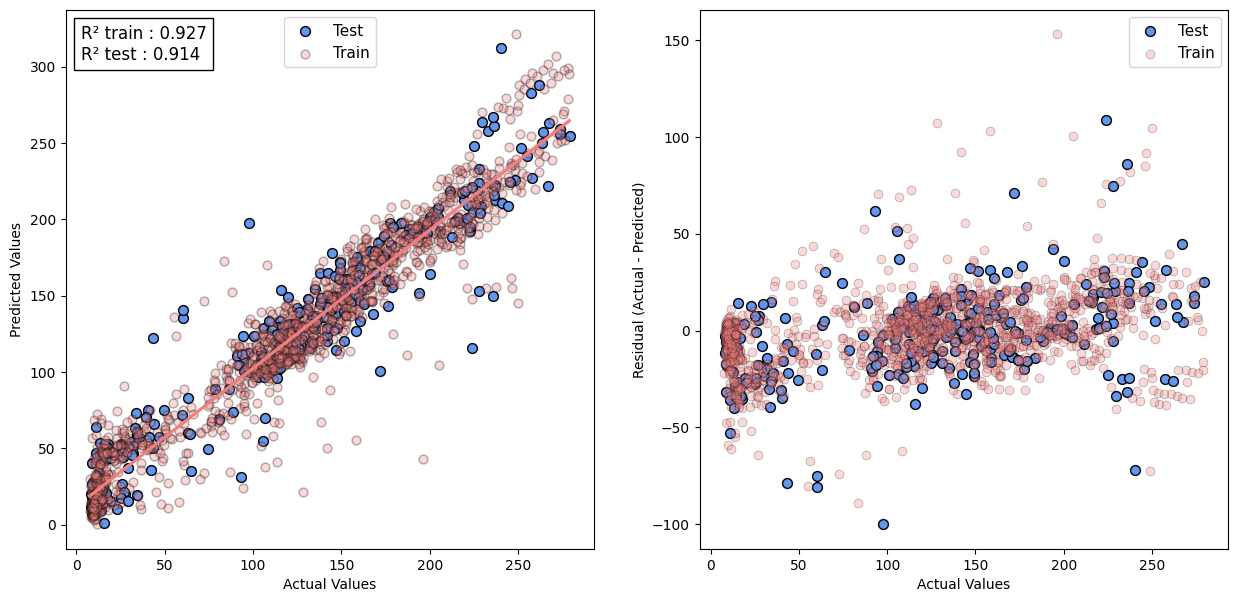

In [267]:
fig = plt.figure(figsize=(15, 7))
grid = plt.GridSpec(1, 2, wspace=0.2, hspace=0.2)
ax1 = plt.subplot(grid[0, 0])
plt.scatter(test_res['actual'],test_res['pred'], color='cornflowerblue', label='Test', linewidths=1, edgecolors='black', s=50)
sns.regplot(data = train_res, x = 'actual',y = 'pred', color='lightcoral', label='Train', scatter_kws={'s':40, 'alpha':0.3, 'edgecolor':'black'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
anchored_text = AnchoredText("R\u00b2 train : "+str(round(r2_score(train_res['actual'],train_res['pred']),3))+'\n'"R\u00b2 test : "+str(round(r2_score(test_res['actual'],test_res['pred']),3)), loc=2,prop=dict(size=12))
ax1.add_artist(anchored_text)
plt.legend(loc = 9, prop={'size': 11})
ax2 = plt.subplot(grid[0, 1])
x = test_res['actual']
y = test_res['pred']
z= x - y

a = train_res['actual']
b = train_res['pred']
c= a - b
plt.scatter(x,z, color='cornflowerblue', label='Test', linewidths=1, edgecolors='black', s=50)
sns.scatterplot(x=a,y=c, color='lightcoral', label='Train', alpha = 0.3, s = 40,edgecolor='black')
plt.xlabel('Actual Values')
plt.ylabel('Residual (Actual - Predicted)')
plt.legend(loc='upper right', prop={'size': 11})
# plt.savefig('reg.tiff', dpi=300, bbox_inches = "tight")